# Air Pollution Visualization (AQICN)

Air pollution trends across our chosen cities in China using aqicn data. It includes seasonal decomposition, heatmaps, city comparisons, and threshold exceedance analysis. This is essentially the first few days of figuring out how to visualize the data and trying to replicate some of the figures given by aqicn. Some overlap with the "grab-bag" that Kaisa provided.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pathlib import Path

sns.set(style="whitegrid")
file_map = {
    "baotou": "aqicn_data/baotou.csv",
    "beijing_west_park": "aqicn_data/beijing, west park.csv",
    "beijing": "aqicn_data/beijing.csv",
    "ganzhou": "aqicn_data/ganzhou.csv",
    "guangzhou": "aqicn_data/guangzhou.csv",
    "kunming": "aqicn_data/kunming",
    "panzhihua": "aqicn_data/panzhihua.csv",
    "quanzhou": "aqicn_data/quanzhou.csv",
    "shanghai": "aqicn_data/shanghai.csv",
    "shenzhen": "aqicn_data/shenzhen.csv",
    "shuozhou": "aqicn_data/shuozhou.csv",
    "tangshan": "aqicn_data/tangshan.csv",
    "wuhan": "aqicn_data/wuhan.csv"
}

def load_city_data(cities, pollutant):
    city_data = {}
    for city in cities:
        path = file_map.get(city)
        if not path:
            continue
        df = pd.read_csv(
            path,
            usecols=['date', pollutant],
            parse_dates=['date'],
            skipinitialspace=True
        )
        df[pollutant] = pd.to_numeric(df[pollutant], errors='coerce')
        df = df.dropna(subset=[pollutant])
        df = df.sort_values('date')  # Ensure dates are in order
        city_data[city] = df
    return city_data


selected_cities = ["baotou", "beijing", "shanghai", "shenzhen", "wuhan"]
pollutant = "pm25"
city_data = load_city_data(selected_cities, pollutant)

## 2. Visualize Grouped Pollution Trends

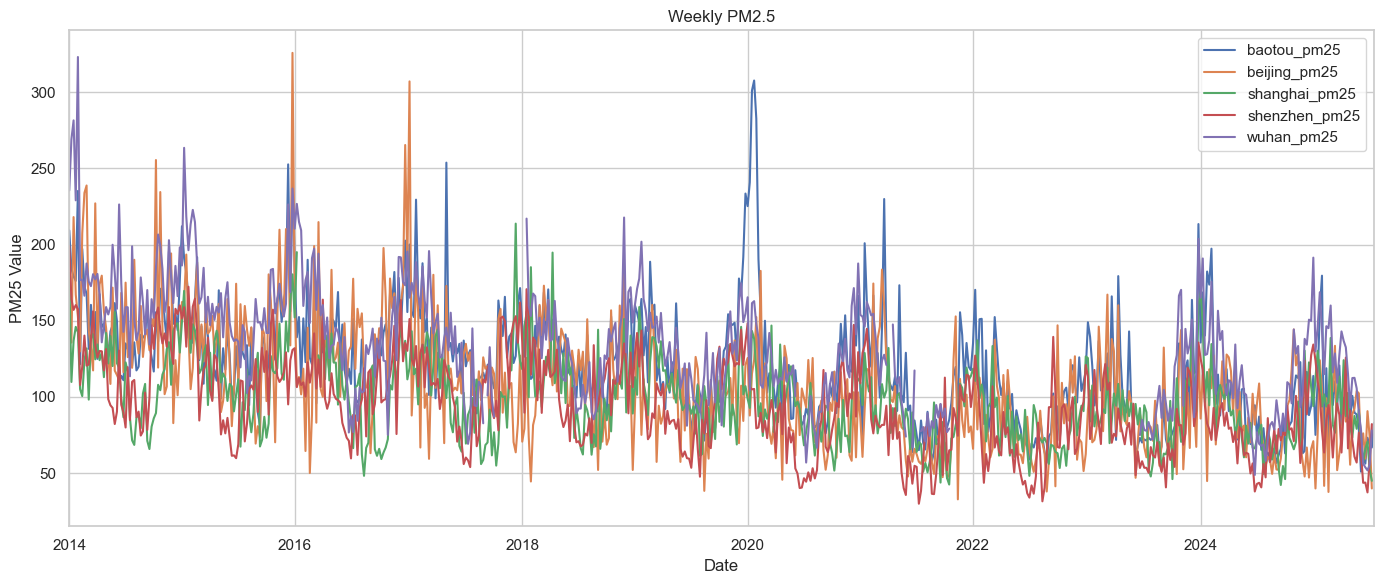

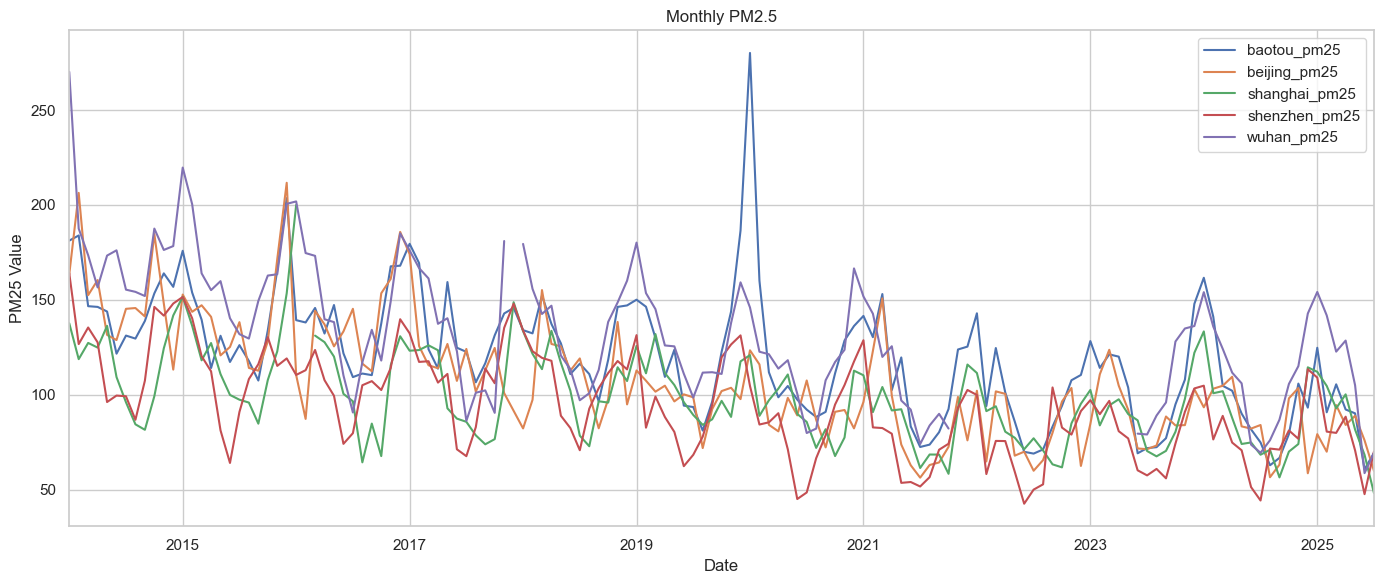

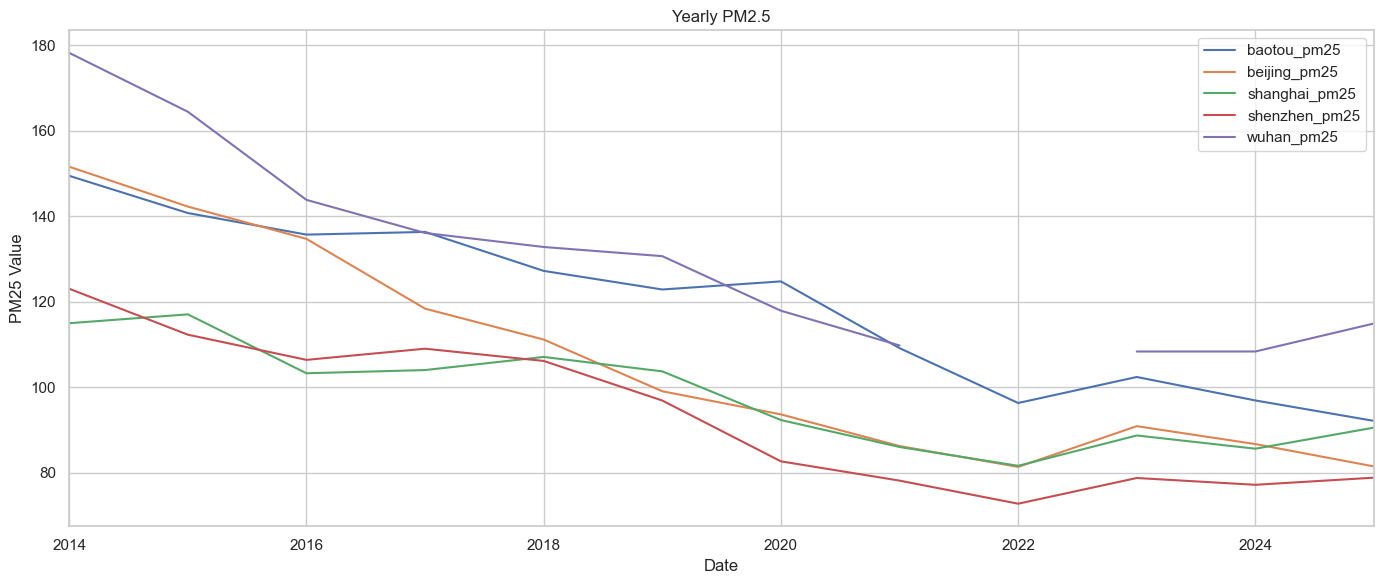

In [2]:
def resample_city_data(city_data, pollutant, freq='M'):
    resampled = {}
    for city, df in city_data.items():
        df = df.set_index('date').resample(freq).mean()
        df.columns = [f"{city}_{pollutant}"]
        resampled[city] = df
    return resampled

def plot_combined_pollutant(city_data, pollutant, freq='M', title=None):
    resampled = resample_city_data(city_data, pollutant, freq)
    combined = pd.concat(resampled.values(), axis=1)
    combined.plot(title=title or f"{freq} Average {pollutant.upper()} Across Cities", figsize=(14, 6))
    plt.ylabel(f"{pollutant.upper()} Value")
    plt.xlabel("Date")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return combined

weekly = plot_combined_pollutant(city_data, pollutant, freq='W', title="Weekly PM2.5")
monthly = plot_combined_pollutant(city_data, pollutant, freq='ME', title="Monthly PM2.5")
yearly = plot_combined_pollutant(city_data, pollutant, freq='YE', title="Yearly PM2.5")

## 3. Monthly Heatmap

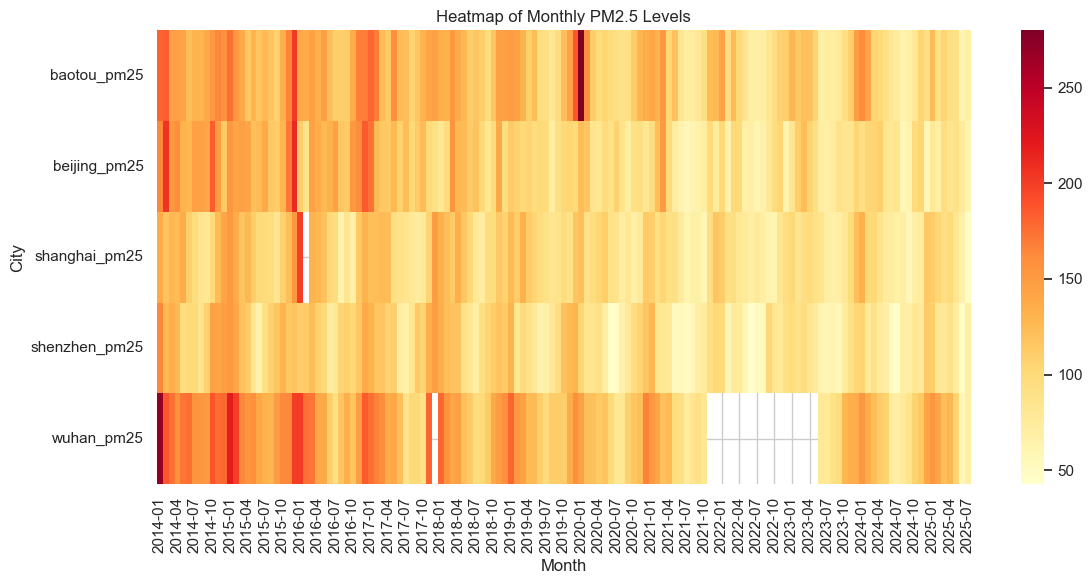

In [3]:
monthly_means = monthly.copy()
monthly_means.index = monthly_means.index.to_period('M')
monthly_means = monthly_means.groupby(monthly_means.index).mean()

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_means.T, annot=False, cmap="YlOrRd", cbar_kws={'label': ''})
plt.title("Heatmap of Monthly PM2.5 Levels")
plt.xlabel("Month")
plt.ylabel("City")
plt.tight_layout()
plt.show()

## 4. Seasonal Decomposition

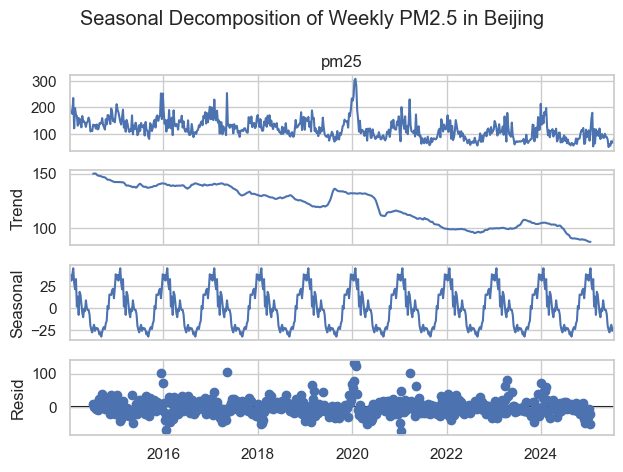

In [4]:
beijing_df = city_data["baotou"].set_index('date').resample('W').mean()
beijing_decomp = seasonal_decompose(beijing_df[pollutant], model='additive', period=52)
beijing_decomp.plot()
plt.rcParams.update({'figure.figsize': (14,14)})
plt.suptitle("Seasonal Decomposition of Weekly PM2.5 in Beijing")
plt.tight_layout()
plt.show()

## 5. Threshold Exceedance Days (WHO: 15 µg/m³ for PM2.5)

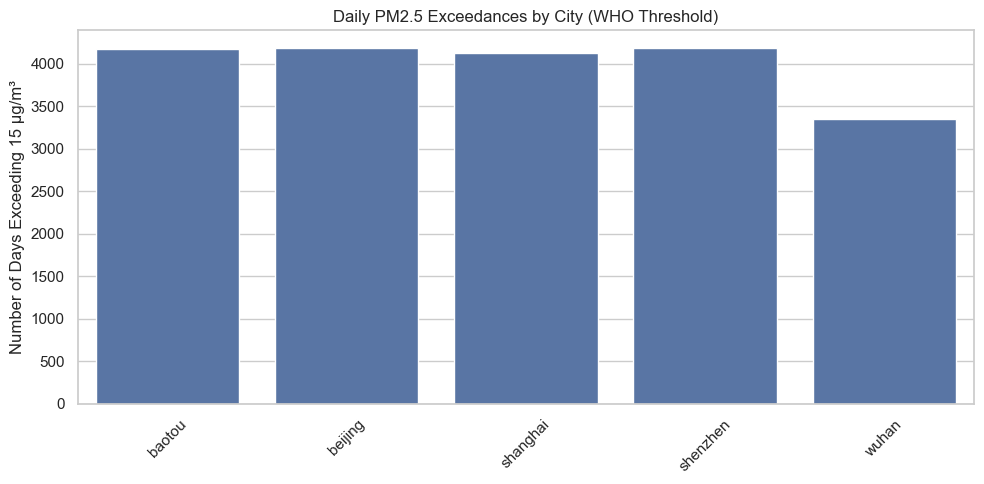

In [5]:
exceedance = {}
threshold = 15
for city, df in city_data.items():
    exceed_days = (df[pollutant] > threshold).sum()
    exceedance[city] = exceed_days

plt.figure(figsize=(10, 5))
sns.barplot(x=list(exceedance.keys()), y=list(exceedance.values()))
plt.xticks(rotation=45)
plt.ylabel("Number of Days Exceeding 15 µg/m³")
plt.title("Daily PM2.5 Exceedances by City (WHO Threshold)")
plt.tight_layout()
plt.show()

## 6. Annual Rankings by Pollution Level

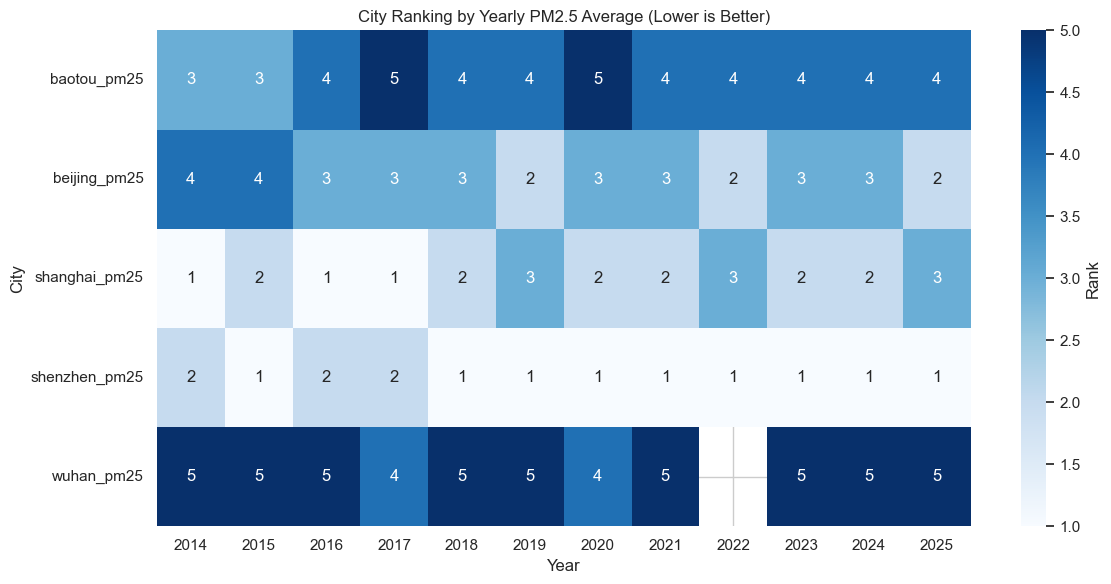

In [6]:
annual_means = yearly.copy()
annual_means.index = annual_means.index.year
ranked = annual_means.rank(axis=1, method='min', ascending=True)

plt.figure(figsize=(12, 6))
sns.heatmap(ranked.T, annot=True, cmap="Blues", cbar_kws={'label': 'Rank'})
plt.title("City Ranking by Yearly PM2.5 Average (Lower is Better)")
plt.xlabel("Year")
plt.ylabel("City")
plt.tight_layout()
plt.show()

## 7. Rolling Averages (7-day)

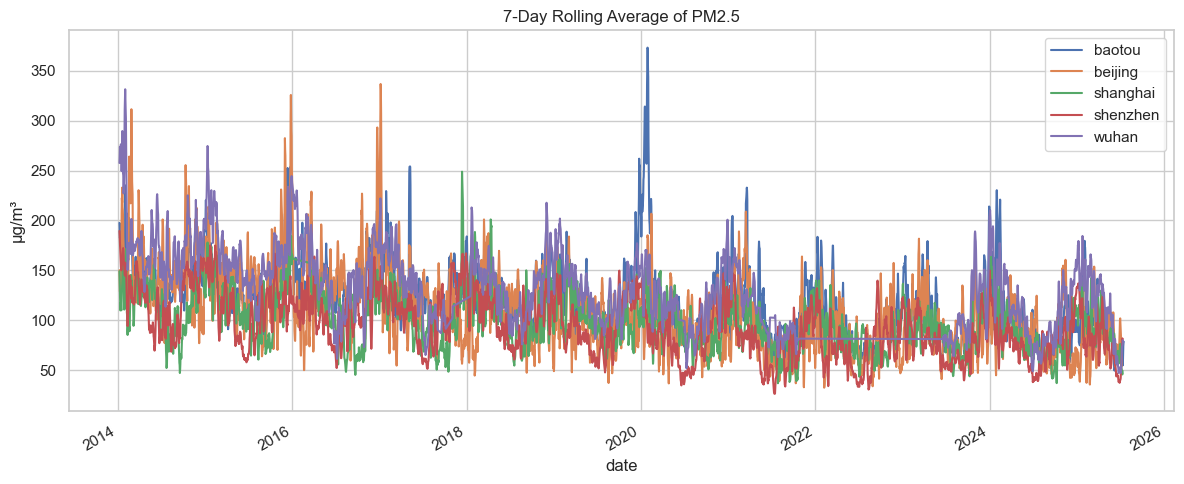

In [7]:
plt.figure(figsize=(12, 5))
for city, df in city_data.items():
    rolled = df.set_index('date')[pollutant].rolling(window=7).mean()
    rolled.plot(label=city)
plt.legend()
plt.title("7-Day Rolling Average of PM2.5")
plt.ylabel("µg/m³")
plt.tight_layout()
plt.show()

## 8. Top 10 Worst Pollution Days per City

In [8]:
for city, df in city_data.items():
    top_days = df.sort_values(by=pollutant, ascending=False).head(10)
    print(f"\nTop 10 {pollutant.upper()} Days in {city}:")
    print(top_days[['date', pollutant]])


Top 10 PM25 Days in baotou:
           date   pm25
1941 2020-01-26  672.0
1622 2021-03-16  658.0
2941 2017-05-05  572.0
4115 2014-02-01  562.0
3025 2017-01-29  516.0
134  2025-01-30  490.0
1927 2020-01-12  409.0
1561 2021-01-14  405.0
509  2024-02-11  402.0
1932 2020-01-17  389.0

Top 10 PM25 Days in beijing:
           date   pm25
3546 2015-12-26  524.0
3190 2017-01-02  495.0
3522 2015-12-02  493.0
3179 2016-12-22  437.0
3178 2016-12-21  433.0
4143 2014-02-16  426.0
3835 2014-10-10  419.0
4153 2014-02-26  419.0
4113 2014-01-17  414.0
3521 2015-12-01  399.0

Top 10 PM25 Days in shanghai:
           date   pm25
2812 2017-12-12  409.0
2811 2017-12-11  409.0
2567 2018-04-09  372.0
2001 2020-03-18  321.0
2418 2018-11-12  296.0
2813 2017-12-13  293.0
2568 2018-04-10  290.0
2002 2020-03-19  275.0
2417 2018-11-11  273.0
3470 2015-12-16  272.0

Top 10 PM25 Days in shenzhen:
           date   pm25
2662 2018-01-23  228.0
2657 2018-01-18  220.0
3453 2016-04-01  215.0
3749 2015-01-22  214.0
3401 